# *Multi-depth hologram generation using ADAM algorithm with phase-only slm*
Implementing `multi-plane hologram` generation using a multi-loss approach.   
In this code, We repeat Tutorial 2.3 (method 2) with optimizing `phase only SLM`(not complex SLM).

In [ ]:
# This tutorial inspired by:
# Chun Chen, Byounghyo Lee, Nan-Nan Li, Minseok Chae, Di Wang, Qiong-Hua Wang, and Byoungho Lee,
# "Multi-depth hologram generation using stochastic gradient descent algorithm with complex loss function,"
# Opt. Express 29, 15089-15103 (2021)
cd ../..

---

## 🌊 **Step 1: Import Pado**
First, you should import `Pado`. Make sure to install all the dependency.

In [2]:
from typing import List
from pado.light import Light
from pado.propagator import Propagator
from pado.math import calculate_psnr, cm, nm, um  # Use units of cm, nm, and um for readability
import torch
import torch.optim as optim
import torch.nn as nn
import pado

## ⚙️ **Step 2: Default value setting**
Sets the values of the variables used in the code. You can change the values in this part to suit your situation.

In [3]:
R = 2000  # number of rows
C = 2000  # number of columns
pitch = 7.2 * um  # physical size of each pixel in [m]
wvl = [660 * nm, 521 * nm, 445 * nm]  # wavelength of the light in [m]
dim = (1, 3, R, C)  # dimension of the light [batch, channel, row, column]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Use the ASM propagation method by default
prop = pado.propagator.Propagator('ASM')

d1 = 50 * cm  # distance from the CGH plane to the first image plane
d2 = 60 * cm  # distance from the CGH plane to the second image plane

## ⛩️ **Step 3: Build SLM field optimizer**
Adapt `optimize_multi_plane_phase_only_loss` function to work with `phase-only SLM`. SLM field will have a constant amplitude of 1, and we'll optimize the phase directly using the ADAM optimizer.

In [ ]:
from typing import List
from pado.light import Light
from pado.propagator import Propagator
from pado.math import calculate_psnr, cm, nm, um
import torch
import torch.optim as optim
import torch.nn as nn

def optimize_multi_plane_phase_only_loss(
    init_light: Light,
    target_lights: List[Light],
    distances: List[float],
    threshold: float = 0.05,
    beta: float = 0.1,
    n_iter: int = 200,
    prop_model: str = 'ASM',
    lr: float = 0.1,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    weight: float = 2.0,
    patience: int = 20  # Number of iterations to wait for PSNR improvement before early stopping
) -> Light:
    """Performs multi-plane hologram optimization using an enhanced loss function for a phase-only SLM.

    Args:
        init_light (Light): Initial complex field for optimization (SLM field)
        target_lights (List[Light]): Target light fields at different planes
        distances (List[float]): Propagation distances to each target plane
        threshold (float=0.05): Threshold for signal/background mask generation
        beta (float=0.1): Initial weight for background loss
        n_iter (int=200): Number of optimization iterations
        prop_model (str='ASM'): Propagation model (default: Angular Spectrum Method)
        lr (float=0.1): Initial learning rate for Adam optimizer
        device (str): Device to run optimization ('cuda' or 'cpu')
        weight (float=2.0): Weight for intensity loss
        patience (int=20): Number of iterations to wait for PSNR improvement before early stopping

    Returns:
        Light: Optimized phase-only SLM field with the highest PSNR
    """
    # Initialize SLM field and propagation model
    slm_field = init_light.clone()
    prop = Propagator(mode=prop_model)

    # Ensure the initial SLM field is phase-only (amplitude = 1)
    slm_field.set_amplitude_ones()

    # Move field tensor to the specified device
    field_tensor = slm_field.get_field().to(device)
    slm_field.set_field(field_tensor)

    # Optimize the phase directly for phase-only SLM
    phase = torch.angle(field_tensor).requires_grad_(True)
    optimizer = optim.Adam([phase], lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=n_iter//3, gamma=0.1)
    loss_fn = nn.MSELoss()

    # Pre-calculate target fields and masks
    target_fields = [target.get_field().to(device).detach() for target in target_lights]
    target_intensities = [target.get_intensity().to(device).detach() for target in target_lights]
    masks = []
    for target_field in target_fields:
        amplitude = torch.abs(target_field)
        mask = (amplitude > threshold).float()  # 1: signal, 0: background
        masks.append(mask)

    # Track the best PSNR and corresponding field
    best_psnr = -float('inf')
    best_field = None
    patience_counter = 0

    # Optimization loop
    for i in range(n_iter):
        optimizer.zero_grad()
        total_loss = 0

        # Gradually reduce the background loss weight as iterations progress
        current_beta = beta * (1 - i / n_iter)

        # Construct phase-only SLM field (amplitude = 1)
        current_field = torch.exp(1j * phase)
        slm_field.set_field(current_field)

        # Calculate loss for each plane
        for target_field, target_intensity, mask, z in zip(target_fields, target_intensities, masks, distances):
            # Propagate to target plane
            recon_field = prop.forward(slm_field, z=-z, band_limit=True)
            recon_complex = recon_field.get_field()  # Reconstructed complex field
            recon_intensity = recon_field.get_intensity()  # Reconstructed intensity

            # Compute complex loss for signal area
            recon_real = recon_complex.real
            recon_imag = recon_complex.imag
            target_real = target_field.real
            target_imag = target_field.imag

            signal_loss_real = loss_fn(recon_real * mask, target_real * mask)
            signal_loss_imag = loss_fn(recon_imag * mask, target_imag * mask)
            signal_loss = signal_loss_real + signal_loss_imag

            # Compute intensity loss for signal area
            intensity_loss = loss_fn(recon_intensity * mask, target_intensity * mask)

            # Compute background loss
            recon_amp = recon_field.get_amplitude()
            target_amp = torch.abs(target_field)
            background_loss = current_beta * loss_fn(recon_amp * (1 - mask), target_amp * (1 - mask))

            # Compute total plane loss
            plane_loss = signal_loss + weight * intensity_loss + background_loss
            total_loss += plane_loss

        # Backpropagation and optimization step
        total_loss.backward()
        optimizer.step()
        scheduler.step()

        # Calculate average PSNR for all target planes
        psnrs = [calculate_psnr(prop.forward(slm_field, z=-z, band_limit=True).get_intensity(), target.get_intensity())
                 for z, target in zip(distances, target_lights)]
        avg_psnr = sum(psnrs) / len(distances)

        # Update best PSNR and field if current PSNR is higher
        if avg_psnr > best_psnr:
            best_psnr = avg_psnr
            best_field = slm_field.clone()  # Clone the current field
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter if no improvement

        # Print progress
        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {total_loss.item():.4f}, Average PSNR: {avg_psnr:.2f}, Best PSNR: {best_psnr:.2f}")

        # Early stopping if PSNR doesn't improve
        if patience_counter >= patience:
            print(f"Early stopping at iteration {i} with best PSNR: {best_psnr:.2f}")
            break

    # Return the field with the highest PSNR
    if best_field is not None:
        best_field.set_field(best_field.get_field().detach())
        return best_field
    else:
        # Fallback to final field if no improvement was tracked (unlikely with proper initialization)
        final_field = torch.exp(1j * phase.data)
        slm_field.set_field(final_field)
        return slm_field

## 🖥️ **Step 4 : Set initial SLM**
Creates an `initial SLM` for optimization.

In [5]:
init_slm = pado.light.Light(dim, pitch, wvl, device=device)
init_slm.set_amplitude_ones()  # Amplitude = 1 for phase-only SLM
init_slm.set_phase_random()

## 🎯 **Step 5 : Set target images and distances**
Set `target images` that we want to optimize and propagate distances.

In [6]:
first_plane = pado.light.Light(dim, pitch, wvl, device=device)
first_plane.load_image(image_path=r'..\asset\PADO_letter.PNG', random_phase=True)

second_plane = pado.light.Light(dim, pitch, wvl, device=device)
second_plane.load_image(image_path=r'..\..\docs\images\logo_extended.png', random_phase=True)

combine_image = pado.light.Light(dim, pitch, wvl, device=device)
combine_image.set_field(first_plane.get_field() + second_plane.get_field())

target_lights = [first_plane, second_plane]
distances = [d1, d2]  # 50cm, 60cm
weights = [0.5, 0.5]  # Equal weights

## 📈 **Step 6 : Perform SLM optimization**
Run `ADAM` optimizer for SLM optimization using `optimize_multi_plane_complex_loss`.

In [7]:
optimized_field = optimize_multi_plane_phase_only_loss(
    init_slm,
    target_lights,
    distances,
    threshold=0.05,
    beta=0.1,
    n_iter=200,
    prop_model='ASM',
    lr=0.1,
    device=device,
    weight=2.0,
    patience=20
)

Iteration 0, Loss: 0.3037, Average PSNR: 9.78, Best PSNR: 9.78
Iteration 10, Loss: 0.2080, Average PSNR: 12.97, Best PSNR: 12.97
Iteration 20, Loss: 0.1815, Average PSNR: 14.76, Best PSNR: 14.76
Iteration 30, Loss: 0.1677, Average PSNR: 15.52, Best PSNR: 15.52
Iteration 40, Loss: 0.1594, Average PSNR: 15.78, Best PSNR: 15.78
Iteration 50, Loss: 0.1536, Average PSNR: 15.96, Best PSNR: 15.96
Iteration 60, Loss: 0.1491, Average PSNR: 16.09, Best PSNR: 16.09
Iteration 70, Loss: 0.1466, Average PSNR: 16.16, Best PSNR: 16.16
Iteration 80, Loss: 0.1457, Average PSNR: 16.17, Best PSNR: 16.17
Iteration 90, Loss: 0.1448, Average PSNR: 16.17, Best PSNR: 16.17
Iteration 100, Loss: 0.1440, Average PSNR: 16.17, Best PSNR: 16.17
Iteration 110, Loss: 0.1431, Average PSNR: 16.17, Best PSNR: 16.17
Early stopping at iteration 119 with best PSNR: 16.17


## 🔍 **Step 7 : Visualize and evaluate results**
Show optimized fields and evaluate the results with the psnr score.


Optimized CGH pattern:


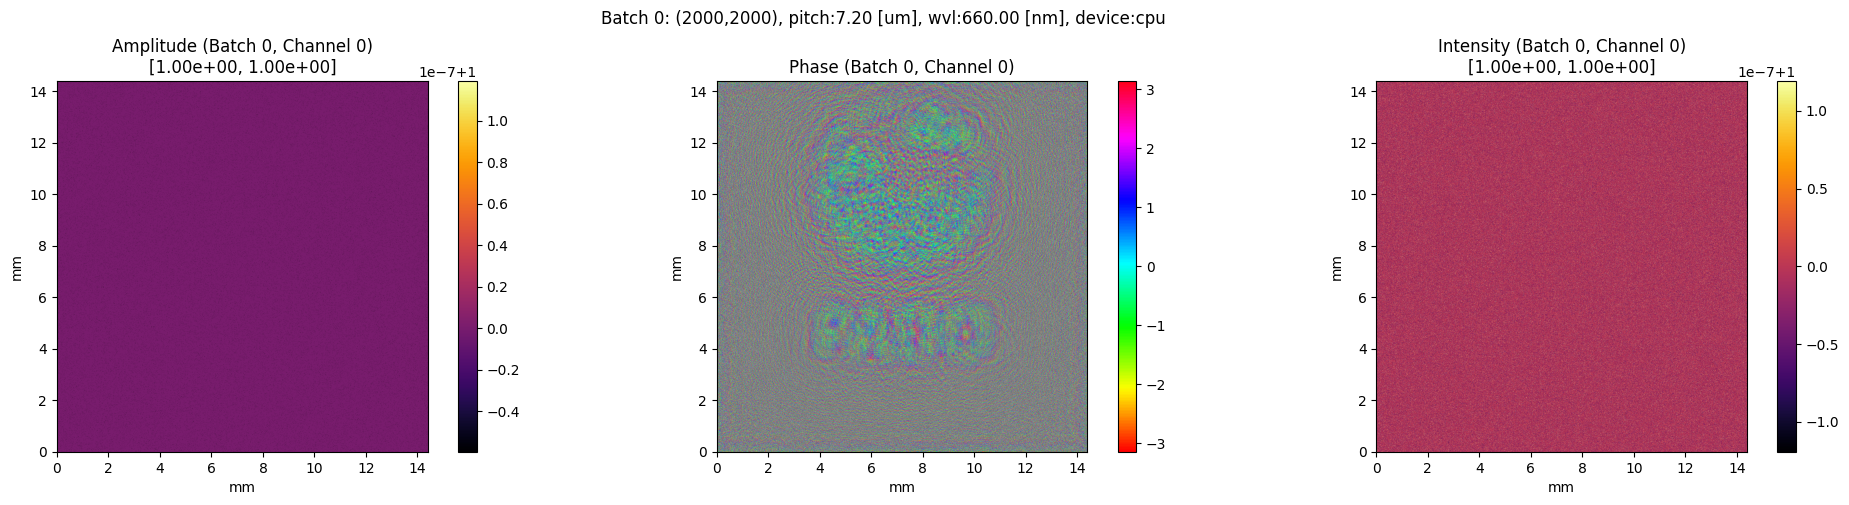


Reconstruction at first plane (d1 = 50cm):


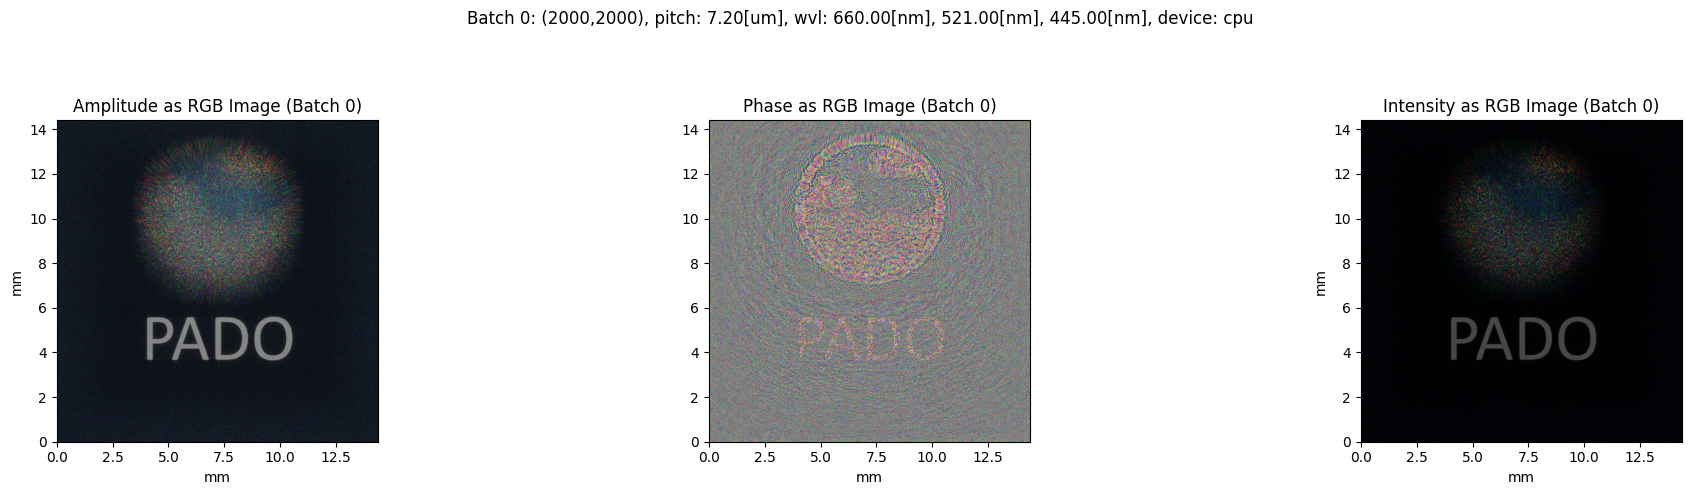


Reconstruction at second plane (d2 = 60cm):


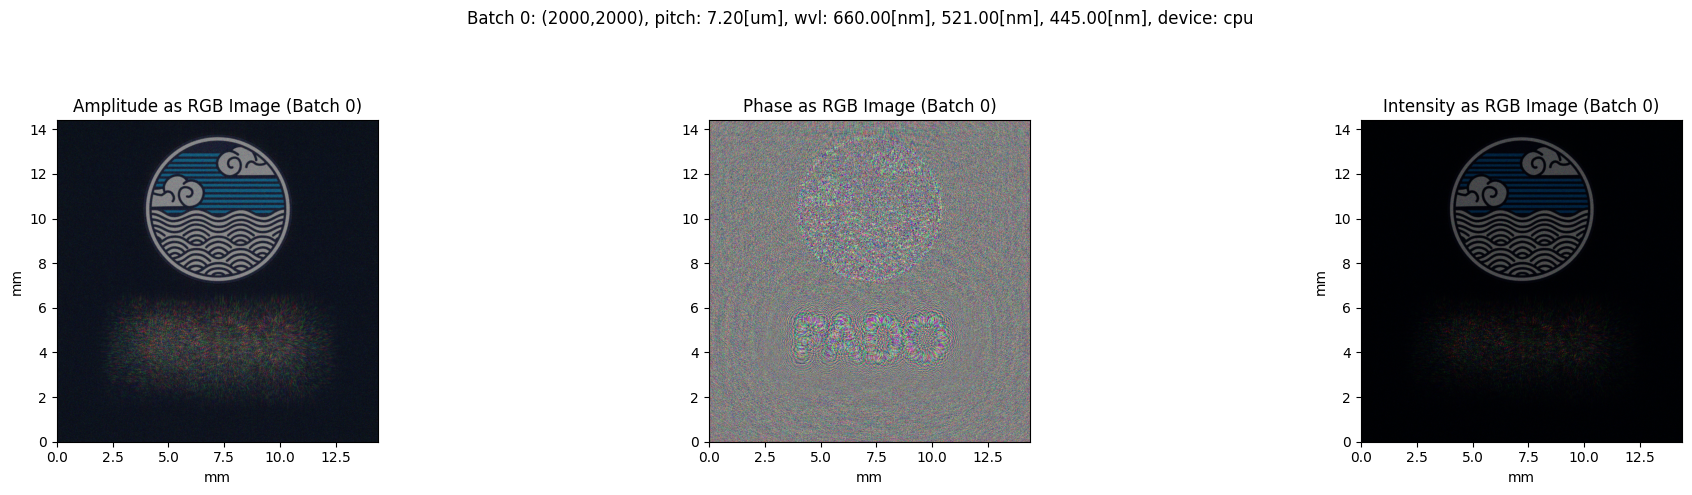


Final PSNR at 50cm: 17.89
Final PSNR at 60cm: 14.41


In [8]:
print("\nOptimized CGH pattern:")
optimized_field.visualize(c=0)

print("\nReconstruction at first plane (d1 = 50cm):")
recon_d1 = prop.forward(optimized_field, -d1)
recon_d1.adjust_amplitude_to_other_light(combine_image)
recon_d1.visualize_image()

print("\nReconstruction at second plane (d2 = 60cm):")
recon_d2 = prop.forward(optimized_field, -d2)
recon_d2.adjust_amplitude_to_other_light(combine_image)
recon_d2.visualize_image()

# Calculate and print PSNR
psnr_d1 = calculate_psnr(recon_d1.get_intensity(), first_plane.get_intensity())
psnr_d2 = calculate_psnr(recon_d2.get_intensity(), second_plane.get_intensity())
print(f"\nFinal PSNR at 50cm: {psnr_d1:.2f}")
print(f"Final PSNR at 60cm: {psnr_d2:.2f}")

---

## **Example**
Using A, B, C, and D pictures with `four different depths` as target images, optimize slm using the above `optimization_multi_plane_complex_loss` function.   `

## 🌊 **Step 1: Import Pado**
First, you should import `Pado`. Make sure to install all the dependency.

In [1]:
from typing import List
from pado.light import Light
from pado.propagator import Propagator
from pado.math import calculate_psnr, cm, nm, um   # Use units of cm, nm, and um for readability.
import torch
import torch.optim as optim
import torch.nn as nn
import pado

## ⚙️ **Step 2: Default value setting**
Sets the values of the variables used in the code. You can change the values in this part to suit your situation.

In [2]:
R = 1718  # number of rows
C = 1564  # number of columns
pitch = 7.2*um  # physical size of each pixel in [m]
wvl = [660*nm, 521*nm, 445*nm] # wavelength of the light in [m]
dim = (1, 3, R, C)  # dimension of the light [batch, channel, row, column]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# By default, we use the ASM method. 
# If you want to use a different propagate method, you can choose the option of Fraunhofer, Fresnel, FFT (Fast Fourier Transform), ASM, and RS.
prop = pado.propagator.Propagator('ASM') 

distances = [50*cm, 60*cm, 70*cm, 80*cm] 

## ⛩️ **Step 3: Build SLM field optimizer**
Adapt `optimize_multi_plane_phase_only_loss` function to work with `phase-only SLM`. SLM field will have a constant amplitude of 1, and we'll optimize the phase directly using the ADAM optimizer.

In [ ]:
from typing import List
from pado.light import Light
from pado.propagator import Propagator
from pado.math import calculate_psnr, cm, nm, um
import torch
import torch.optim as optim
import torch.nn as nn

def optimize_multi_plane_phase_only_loss(
    init_light: Light,
    target_lights: List[Light],
    distances: List[float],
    threshold: float = 0.05,
    beta: float = 0.1,
    n_iter: int = 200,
    prop_model: str = 'ASM',
    lr: float = 0.1,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    weight: float = 2.0,
    patience: int = 20  # Number of iterations to wait for PSNR improvement before early stopping
) -> Light:
    """Performs multi-plane hologram optimization using an enhanced loss function for a phase-only SLM.

    Args:
        init_light (Light): Initial complex field for optimization (SLM field)
        target_lights (List[Light]): Target light fields at different planes
        distances (List[float]): Propagation distances to each target plane
        threshold (float=0.05): Threshold for signal/background mask generation
        beta (float=0.1): Initial weight for background loss
        n_iter (int=200): Number of optimization iterations
        prop_model (str='ASM'): Propagation model (default: Angular Spectrum Method)
        lr (float=0.1): Initial learning rate for Adam optimizer
        device (str): Device to run optimization ('cuda' or 'cpu')
        weight (float=2.0): Weight for intensity loss
        patience (int=20): Number of iterations to wait for PSNR improvement before early stopping

    Returns:
        Light: Optimized phase-only SLM field with the highest PSNR
    """
    # Initialize SLM field and propagation model
    slm_field = init_light.clone()
    prop = Propagator(mode=prop_model)

    # Ensure the initial SLM field is phase-only (amplitude = 1)
    slm_field.set_amplitude_ones()

    # Move field tensor to the specified device
    field_tensor = slm_field.get_field().to(device)
    slm_field.set_field(field_tensor)

    # Optimize the phase directly for phase-only SLM
    phase = torch.angle(field_tensor).requires_grad_(True)
    optimizer = optim.Adam([phase], lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=n_iter//3, gamma=0.1)
    loss_fn = nn.MSELoss()

    # Pre-calculate target fields and masks
    target_fields = [target.get_field().to(device).detach() for target in target_lights]
    target_intensities = [target.get_intensity().to(device).detach() for target in target_lights]
    masks = []
    for target_field in target_fields:
        amplitude = torch.abs(target_field)
        mask = (amplitude > threshold).float()  # 1: signal, 0: background
        masks.append(mask)

    # Track the best PSNR and corresponding field
    best_psnr = -float('inf')
    best_field = None
    patience_counter = 0

    # Optimization loop
    for i in range(n_iter):
        optimizer.zero_grad()
        total_loss = 0

        # Gradually reduce the background loss weight as iterations progress
        current_beta = beta * (1 - i / n_iter)

        # Construct phase-only SLM field (amplitude = 1)
        current_field = torch.exp(1j * phase)
        slm_field.set_field(current_field)

        # Calculate loss for each plane
        for target_field, target_intensity, mask, z in zip(target_fields, target_intensities, masks, distances):
            # Propagate to target plane
            recon_field = prop.forward(slm_field, z=-z, band_limit=True)
            recon_complex = recon_field.get_field()  # Reconstructed complex field
            recon_intensity = recon_field.get_intensity()  # Reconstructed intensity

            # Compute complex loss for signal area
            recon_real = recon_complex.real
            recon_imag = recon_complex.imag
            target_real = target_field.real
            target_imag = target_field.imag

            signal_loss_real = loss_fn(recon_real * mask, target_real * mask)
            signal_loss_imag = loss_fn(recon_imag * mask, target_imag * mask)
            signal_loss = signal_loss_real + signal_loss_imag

            # Compute intensity loss for signal area
            intensity_loss = loss_fn(recon_intensity * mask, target_intensity * mask)

            # Compute background loss
            recon_amp = recon_field.get_amplitude()
            target_amp = torch.abs(target_field)
            background_loss = current_beta * loss_fn(recon_amp * (1 - mask), target_amp * (1 - mask))

            # Compute total plane loss
            plane_loss = signal_loss + weight * intensity_loss + background_loss
            total_loss += plane_loss

        # Backpropagation and optimization step
        total_loss.backward()
        optimizer.step()
        scheduler.step()

        # Calculate average PSNR for all target planes
        psnrs = [calculate_psnr(prop.forward(slm_field, z=-z, band_limit=True).get_intensity(), target.get_intensity())
                 for z, target in zip(distances, target_lights)]
        avg_psnr = sum(psnrs) / len(distances)

        # Update best PSNR and field if current PSNR is higher
        if avg_psnr > best_psnr:
            best_psnr = avg_psnr
            best_field = slm_field.clone()  # Clone the current field
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter if no improvement

        # Print progress
        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {total_loss.item():.4f}, Average PSNR: {avg_psnr:.2f}, Best PSNR: {best_psnr:.2f}")

        # Early stopping if PSNR doesn't improve
        if patience_counter >= patience:
            print(f"Early stopping at iteration {i} with best PSNR: {best_psnr:.2f}")
            break

    # Return the field with the highest PSNR
    if best_field is not None:
        best_field.set_field(best_field.get_field().detach())
        return best_field
    else:
        # Fallback to final field if no improvement was tracked (unlikely with proper initialization)
        final_field = torch.exp(1j * phase.data)
        slm_field.set_field(final_field)
        return slm_field

## 🖥️ **Step 4 : Set initial SLM**
Creates an `initial SLM` for optimization.

In [4]:
init_slm = pado.light.Light(dim, pitch, wvl, device=device)
init_slm.set_amplitude_ones()
init_slm.set_phase_random()

## 🎯 **Step 5: Set target images**
Set `target images` that we want to optimize.

In [5]:
target_lights = []
image_paths = {  # Image paths for each target
    'A': '../asset/A.png',
    'B': '../asset/B.png',
    'C': '../asset/C.png',
    'D': '../asset/D.png'
}
for letter, path in image_paths.items():
    target = Light(dim=dim, pitch=pitch, wvl=wvl, device=device)
    target.load_image(image_path=path, random_phase=True)
    target_lights.append(target)

## 📈 **Step 6 : Perform SLM optimization**
Run `ADAM` optimizer for SLM optimization using `optimize_multi_plane_complex_loss`.

In [6]:
print("\n=== Optimizing with optimize_multi_plane_complex_loss ===")
optimized_field = optimize_multi_plane_phase_only_loss(
    init_light=init_slm,
    target_lights=target_lights,
    distances=distances,
    threshold=0.05,
    beta=0.1,
    n_iter=150, 
    lr=0.15,
    device=device,
    weight=2.0
)


=== Optimizing with optimize_multi_plane_complex_loss ===
Iteration 0, Loss: 0.2002, Average PSNR: 13.36, Best PSNR: 13.36
Iteration 10, Loss: 0.1142, Average PSNR: 19.97, Best PSNR: 19.97
Iteration 20, Loss: 0.1044, Average PSNR: 20.34, Best PSNR: 20.34
Iteration 30, Loss: 0.0980, Average PSNR: 20.84, Best PSNR: 20.84
Iteration 40, Loss: 0.0943, Average PSNR: 21.12, Best PSNR: 21.12
Iteration 50, Loss: 0.0914, Average PSNR: 21.34, Best PSNR: 21.34
Iteration 60, Loss: 0.0903, Average PSNR: 21.35, Best PSNR: 21.35
Iteration 70, Loss: 0.0893, Average PSNR: 21.33, Best PSNR: 21.35
Early stopping at iteration 77 with best PSNR: 21.35


## 🔍 **Step 7 : Visualize and evaluate results**
Show optimized fields and evaluate the results with the psnr score.


Reconstruction Results:
Letter A at z=0.5m, PSNR: 20.64 dB


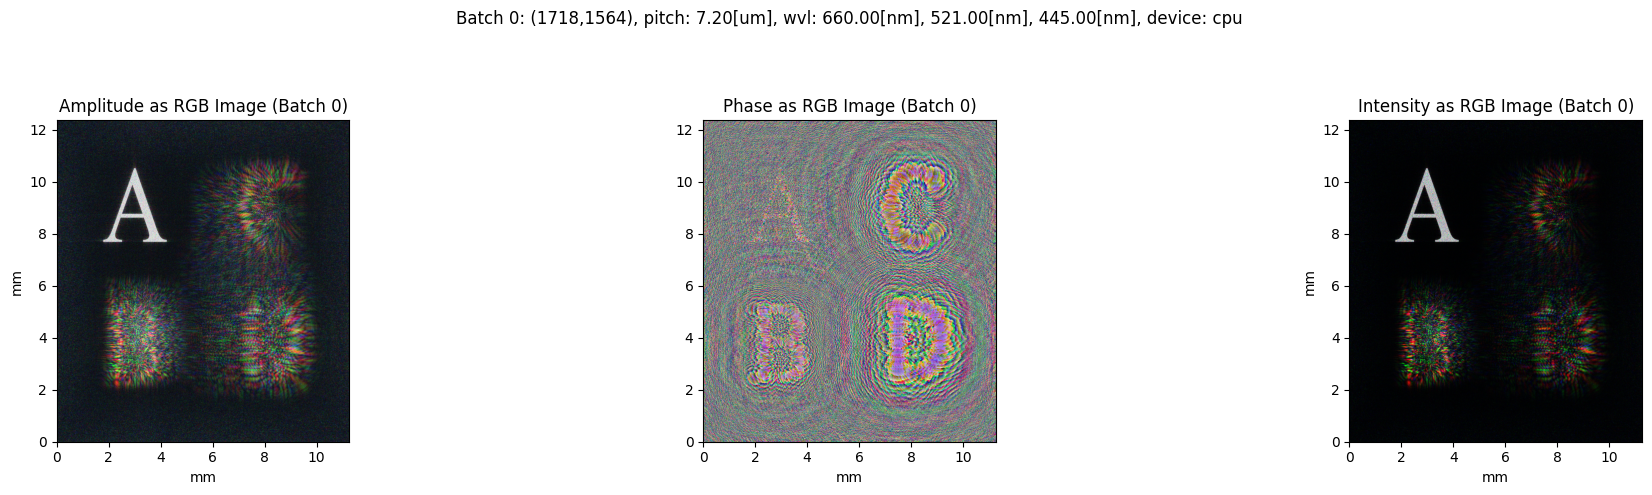

Letter B at z=0.6m, PSNR: 20.92 dB


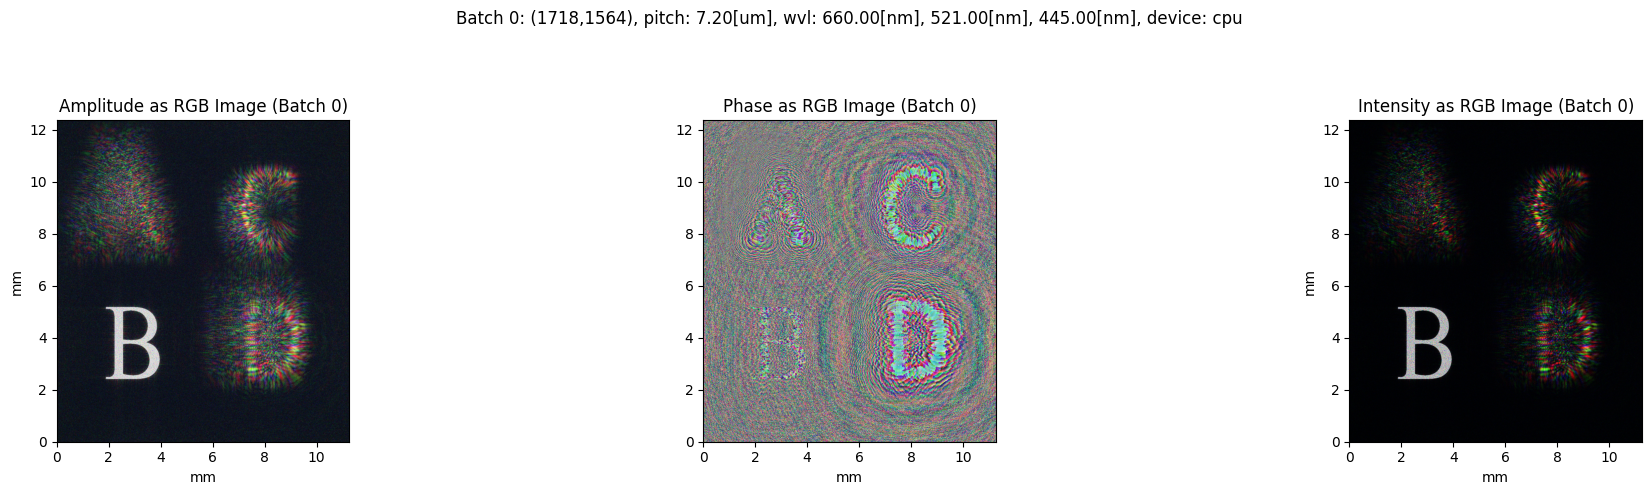

Letter C at z=0.7000000000000001m, PSNR: 20.83 dB


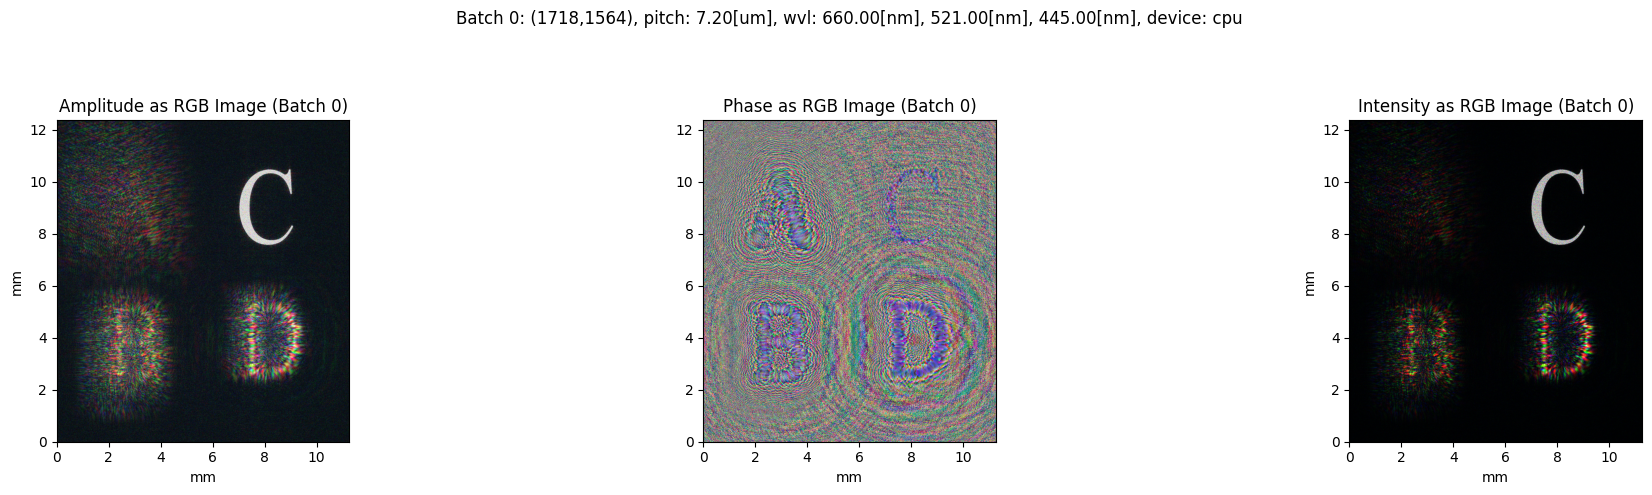

Letter D at z=0.8m, PSNR: 23.01 dB


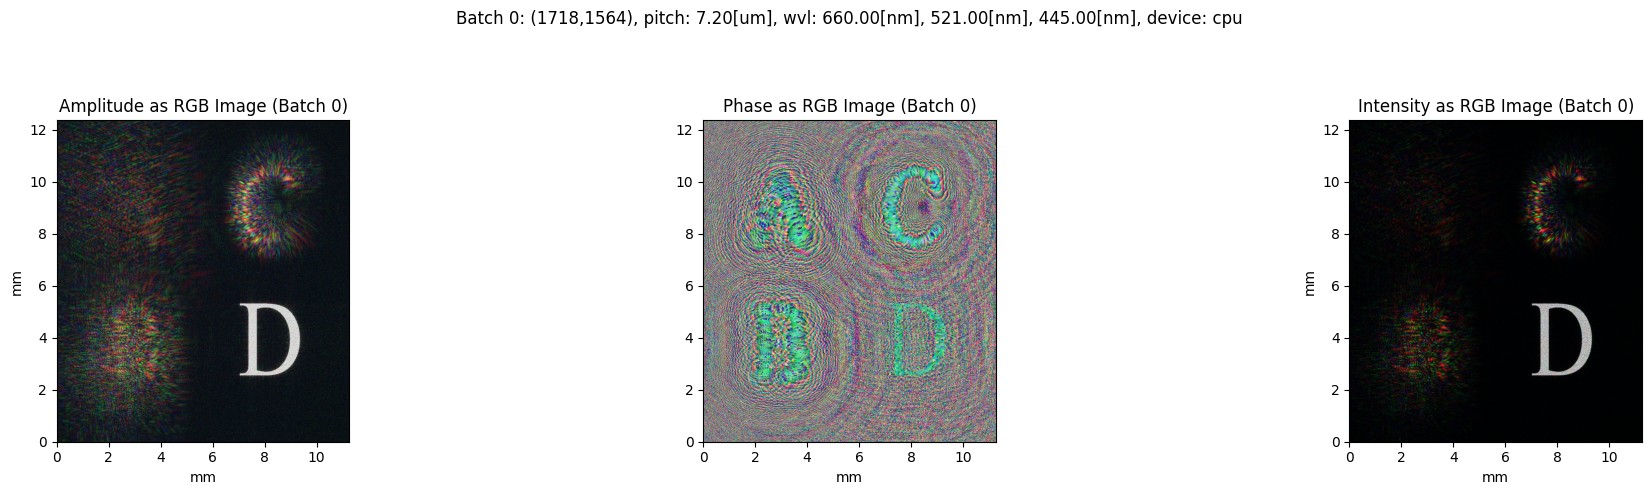


Optimized CGH pattern:


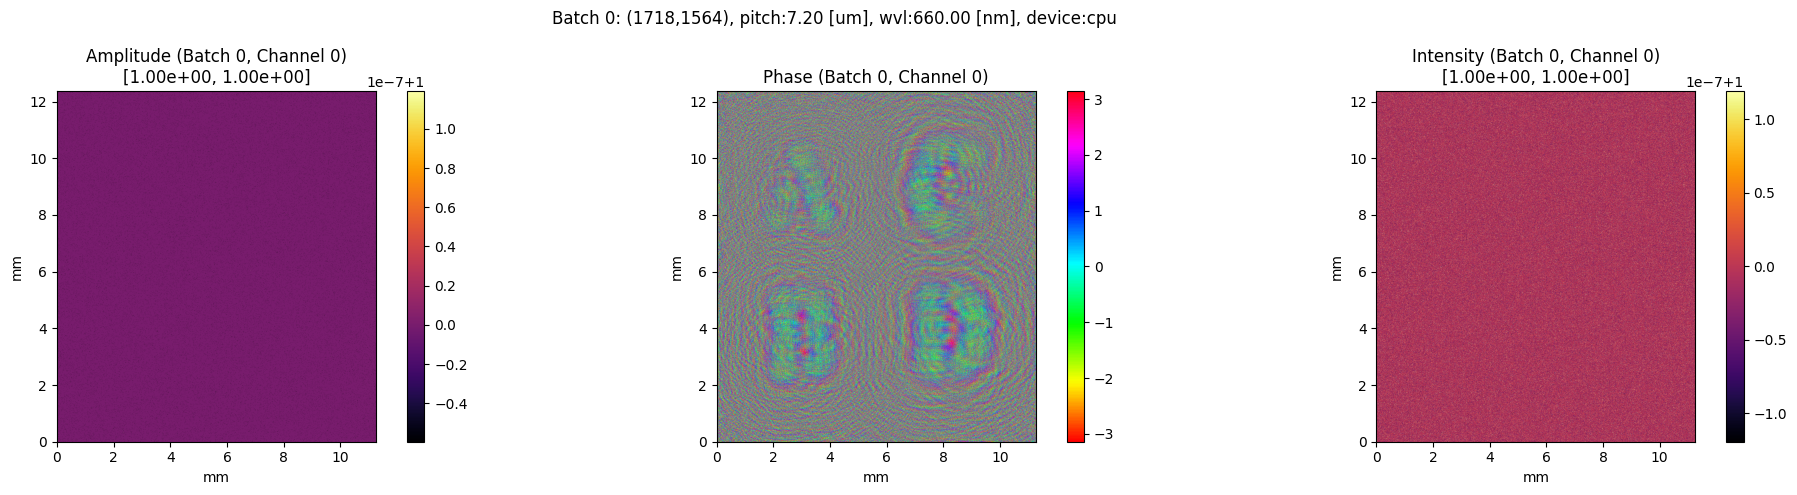

In [7]:
print("\nReconstruction Results:")
for z, target, letter in zip(distances, target_lights, ['A', 'B', 'C', 'D']):
    recon_field = prop.forward(optimized_field, z=-z, band_limit=True)
    psnr = calculate_psnr(recon_field.get_intensity(), target.get_intensity())
    print(f"Letter {letter} at z={z}m, PSNR: {psnr:.2f} dB")
    recon_field.visualize_image()

# Visualize the optimized CGH pattern
print("\nOptimized CGH pattern:")
optimized_field.visualize(c=0)